In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import numpy as np

# Define the models to analyze
models_to_analyze = ['bilstm', 'transformer', 'fasttext']

# Dictionary to hold the full analysis data for each model
all_model_data = {}
all_model_summary = {}

print("Loading detailed error analysis data for all models (using high_confidence_errors and summaries)...\n")

for model_name in models_to_analyze:
    pkl_file = f'../results/error_analysis/{model_name}/detailed_error_analysis.pkl'
    try:
        with open(pkl_file, 'rb') as f:
            raw_data = pickle.load(f)
        
        # Store summary statistics
        summary_info = {
            'total_samples': raw_data['total_samples'],
            'total_errors': raw_data['total_errors'],
            'error_rate': raw_data['error_rate'],
            'errors_by_class': raw_data['errors_by_class'],
            'confusion_patterns': raw_data['confusion_patterns'],
            'length_analysis': raw_data['length_analysis'],
            'confidence_analysis': raw_data['confidence_analysis'],
        }
        all_model_summary[model_name] = summary_info
        
        # Load the high confidence errors (or all errors if a full list exists elsewhere)
        # Assuming 'high_confidence_errors' is the most detailed per-sample list available
        detailed_errors_list = raw_data.get('high_confidence_errors', [])
        
        # Create DataFrame from the list of dictionaries
        if detailed_errors_list:
            error_df = pd.DataFrame(detailed_errors_list)
            # Calculate text length if not already present in the dict/DF
            if 'calculated_text_length' not in error_df.columns:
                 error_df['calculated_text_length'] = error_df['text'].apply(lambda x: len(str(x).split()))
            all_model_data[model_name] = error_df
            print(f"✅ Loaded {len(error_df)} high-confidence error examples for {model_name}.")
        else:
            print(f"⚠️  No detailed error list found for {model_name}. Summary data loaded.")
            all_model_data[model_name] = pd.DataFrame() # Empty DF as placeholder

    except FileNotFoundError:
        print(f"❌ File not found: {pkl_file}")
        all_model_data[model_name] = pd.DataFrame()
        all_model_summary[model_name] = {}
    except Exception as e:
        print(f"❌ Error loading {pkl_file}: {e}")
        all_model_data[model_name] = pd.DataFrame()
        all_model_summary[model_name] = {}

print("\nData loading complete.")

Loading detailed error analysis data for all models (using high_confidence_errors and summaries)...

✅ Loaded 20 high-confidence error examples for bilstm.
✅ Loaded 20 high-confidence error examples for transformer.
✅ Loaded 20 high-confidence error examples for fasttext.

Data loading complete.


In [7]:
# Compare summary statistics
summary_stats = []

for model_name, summary in all_model_summary.items():
    if summary:
        summary_stats.append({
            'Model': model_name,
            'Total Samples': summary['total_samples'],
            'Total Errors': summary['total_errors'],
            'Error Rate': summary['error_rate'],
            'Avg Confidence (All)': summary['confidence_analysis'].get('avg_confidence_all', 'N/A'),
            'Avg Confidence (Errors)': summary['confidence_analysis'].get('avg_confidence_errors', 'N/A')
        })
    else:
        summary_stats.append({
            'Model': model_name,
            'Total Samples': 'N/A',
            'Total Errors': 'N/A',
            'Error Rate': 'N/A',
            'Avg Confidence (All)': 'N/A',
            'Avg Confidence (Errors)': 'N/A'
        })

summary_df = pd.DataFrame(summary_stats)
print("\nSUMMARY STATISTICS ACROSS MODELS")
print("="*80)
print(summary_df.round(4))


SUMMARY STATISTICS ACROSS MODELS
         Model  Total Samples  Total Errors  Error Rate  Avg Confidence (All)  \
0       bilstm           3124          1102      0.3528                0.5136   
1  transformer           3124           969      0.3102                0.5615   
2     fasttext           3124          1086      0.3476                0.5488   

   Avg Confidence (Errors)  
0                   0.4740  
1                   0.5048  
2                   0.4945  


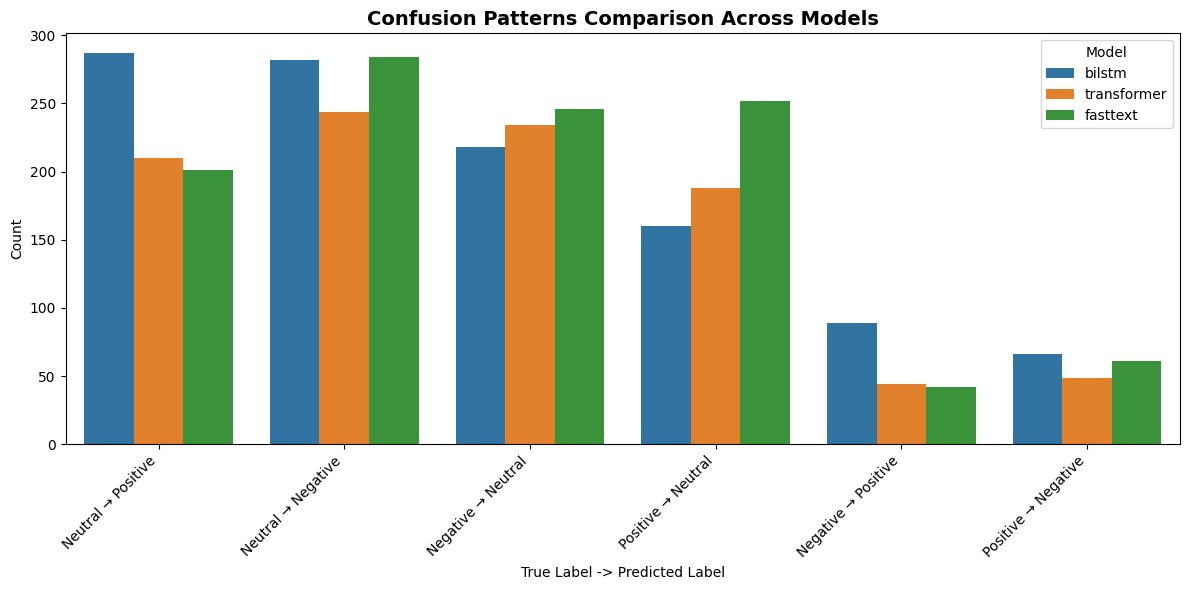

In [8]:
import matplotlib.pyplot as plt

# Extract confusion patterns for each model
confusion_data = []
for model_name, summary in all_model_summary.items():
    if summary and 'confusion_patterns' in summary:
        for pattern, count in summary['confusion_patterns'].items():
            confusion_data.append({'Model': model_name, 'Pattern': pattern, 'Count': count})

if confusion_data:
    confusion_df = pd.DataFrame(confusion_data)
    
    plt.figure(figsize=(12, 6))
    sns.barplot(data=confusion_df, x='Pattern', y='Count', hue='Model')
    plt.xticks(rotation=45, ha='right')
    plt.title('Confusion Patterns Comparison Across Models', fontsize=14, fontweight='bold')
    plt.xlabel('True Label -> Predicted Label')
    plt.ylabel('Count')
    plt.legend(title='Model')
    plt.tight_layout()
    plt.show()
else:
    print("No confusion pattern data available for comparison.")

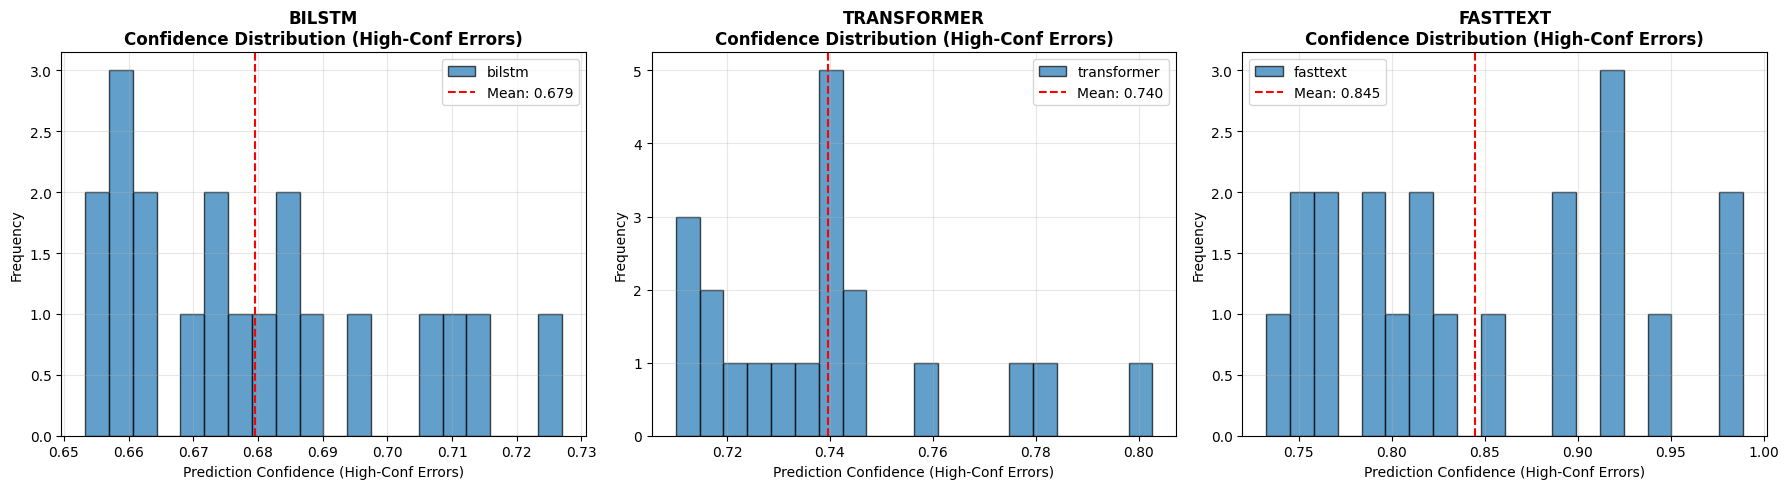


HIGH-CONFIDENCE ERROR CONFIDENCE RANGES (per model)
BILSTM: Min=0.653, Max=0.727, Mean=0.679
TRANSFORMER: Min=0.710, Max=0.803, Mean=0.740
FASTTEXT: Min=0.733, Max=0.989, Mean=0.845


In [ ]:
valid_models_data = {name: data for name, data in all_model_data.items() if not data.empty}

if valid_models_data:
    fig, axes = plt.subplots(1, len(valid_models_data), figsize=(6*len(valid_models_data), 5))
    if len(valid_models_data) == 1:
        axes = [axes]

    ax_idx = 0
    for model_name, data in valid_models_data.items():
        if not data.empty: # Double-check
            axes[ax_idx].hist(data['confidence'], bins=20, edgecolor='black', alpha=0.7, label=model_name)
            axes[ax_idx].set_xlabel('Prediction Confidence (High-Conf Errors)')
            axes[ax_idx].set_ylabel('Frequency')
            axes[ax_idx].set_title(f'{model_name.upper()}\nConfidence Distribution (High-Conf Errors)', fontsize=12, fontweight='bold')
            axes[ax_idx].axvline(data['confidence'].mean(), color='r', linestyle='--', 
                                 label=f'Mean: {data["confidence"].mean():.3f}')
            axes[ax_idx].legend()
            axes[ax_idx].grid(True, alpha=0.3)
            ax_idx += 1

    plt.tight_layout()
    plt.show()

    # Compare pie charts for confidence breakdowns - This is trickier as we only have high-conf errors
    # Let's just show the range of confidences observed in the high_conf set
    print("\nHIGH-CONFIDENCE ERROR CONFIDENCE RANGES (per model)")
    print("="*80)
    for model_name, data in valid_models_data.items():
        if not data.empty:
            min_conf = data['confidence'].min()
            max_conf = data['confidence'].max()
            mean_conf = data['confidence'].mean()
            print(f"{model_name.upper()}: Min={min_conf:.3f}, Max={max_conf:.3f}, Mean={mean_conf:.3f}")

else:
    print("No valid model data with high-confidence errors to plot confidence distributions.")

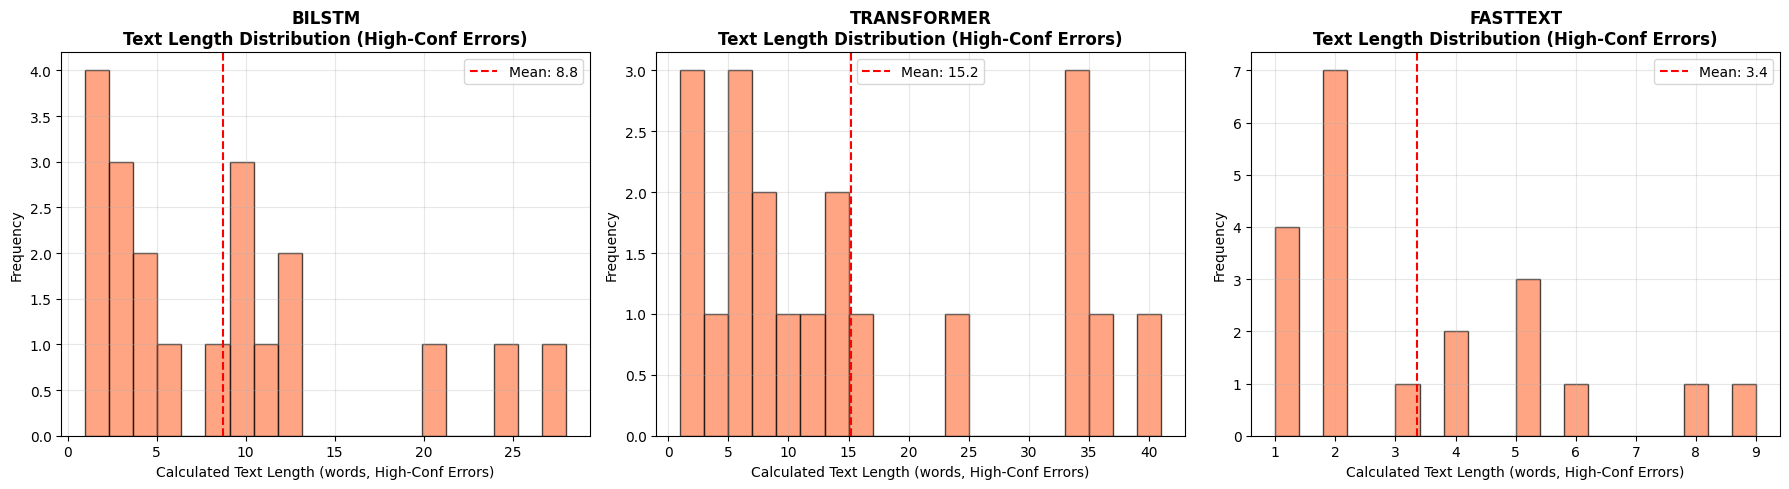

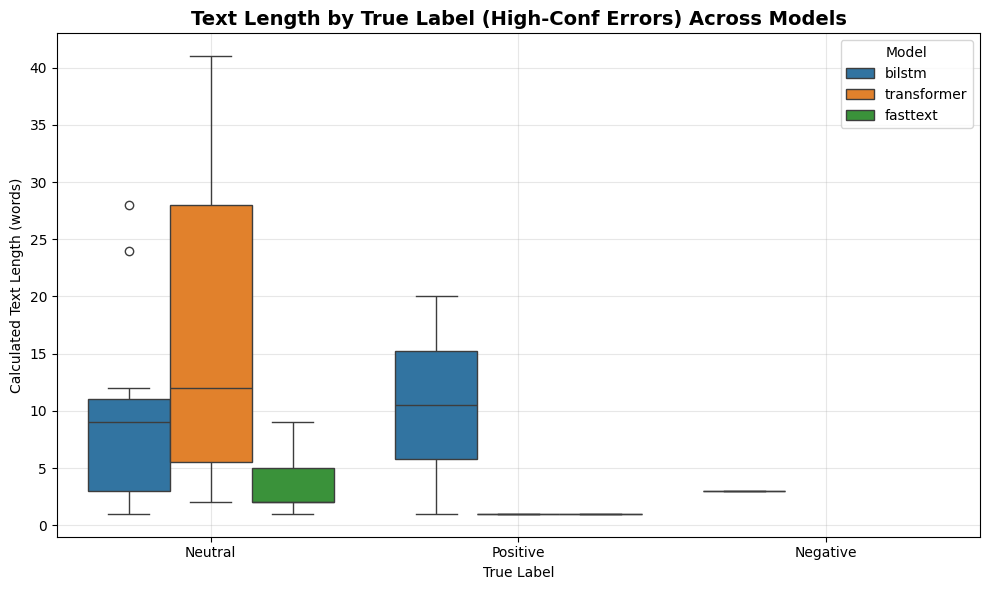

In [10]:
valid_models_data = {name: data for name, data in all_model_data.items() if not data.empty}

if valid_models_data:
    fig, axes = plt.subplots(1, len(valid_models_data), figsize=(6*len(valid_models_data), 5))
    if len(valid_models_data) == 1:
        axes = [axes]

    ax_idx = 0
    for model_name, data in valid_models_data.items():
        if not data.empty: # Double-check
            axes[ax_idx].hist(data['calculated_text_length'], bins=20, edgecolor='black', alpha=0.7, color='coral')
            axes[ax_idx].set_xlabel('Calculated Text Length (words, High-Conf Errors)')
            axes[ax_idx].set_ylabel('Frequency')
            axes[ax_idx].set_title(f'{model_name.upper()}\nText Length Distribution (High-Conf Errors)', fontsize=12, fontweight='bold')
            axes[ax_idx].axvline(data['calculated_text_length'].mean(), color='r', linestyle='--',
                                 label=f'Mean: {data["calculated_text_length"].mean():.1f}')
            axes[ax_idx].legend()
            axes[ax_idx].grid(True, alpha=0.3)
            ax_idx += 1

    plt.tight_layout()
    plt.show()

    # Combine data for a box plot comparison
    all_data_combined = []
    for model_name, data in valid_models_data.items():
        if not data.empty:
            temp_df = data[['calculated_text_length', 'true_label']].copy()
            temp_df['Model'] = model_name
            all_data_combined.append(temp_df)

    if all_data_combined:
        combined_df = pd.concat(all_data_combined, ignore_index=True)
        plt.figure(figsize=(10, 6))
        sns.boxplot(data=combined_df, x='true_label', y='calculated_text_length', hue='Model')
        plt.title('Text Length by True Label (High-Conf Errors) Across Models', fontsize=14, fontweight='bold')
        plt.xlabel('True Label')
        plt.ylabel('Calculated Text Length (words)')
        plt.legend(title='Model')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

else:
    print("No valid model data with high-confidence errors to plot text length distributions.")

In [11]:
print("\nTOP HIGHEST CONFIDENCE ERRORS ACROSS ALL MODELS")
print("="*80)

for model_name, data in all_model_data.items():
    if not data.empty:
        print(f"\n--- {model_name.upper()} (Top 5 High-Conf Errors) ---")
        sorted_errors = data.sort_values('confidence', ascending=False)
        for _, row in sorted_errors.head(5).iterrows():
            print(f"  Confidence: {row['confidence']:.3f} | True: {row['true_label']} | Pred: {row['predicted_label']}")
            print(f"    Text: {row['text'][:100]}...") # Print first 100 chars
            print("    " + "-" * 40)
    else:
        print(f"\n--- {model_name.upper()} ---")
        print("    No high-confidence error data available.")


TOP HIGHEST CONFIDENCE ERRORS ACROSS ALL MODELS

--- BILSTM (Top 5 High-Conf Errors) ---
  Confidence: 0.727 | True: Neutral | Pred: Positive
    Text: Amazing and helpful...
    ----------------------------------------
  Confidence: 0.712 | True: Neutral | Pred: Positive
    Text: Edward Cullen. <3  Hahaha....
    ----------------------------------------
  Confidence: 0.709 | True: Neutral | Pred: Positive
    Text:    All this flirting going on - The ATG smiles. Yay.  ((hugs))...
    ----------------------------------------
  Confidence: 0.705 | True: Neutral | Pred: Positive
    Text:  YAY! Thanks for the #followfriday. #FAILFriday is still winning, though....
    ----------------------------------------
  Confidence: 0.695 | True: Neutral | Pred: Positive
    Text:  yes the new one, I adore both though  who doesn`t love Vincent!!!...
    ----------------------------------------

--- TRANSFORMER (Top 5 High-Conf Errors) ---
  Confidence: 0.803 | True: Neutral | Pred: Positive
    T

In [27]:
print("\nHIGH CONFIDENCE ERRORS (Model was very wrong)")
print("="*80)

high_conf_errors = error_df[error_df['confidence'] >= 0.8].sort_values('confidence', ascending=False)

for idx, row in high_conf_errors.head(10).iterrows():
    print(f"\nConfidence: {row['confidence']:.3f}")
    print(f"True: {row['true_label']} | Predicted: {row['predicted_label']}")
    print(f"Text: {row['text'][:150]}...")
    print("-"*80)


HIGH CONFIDENCE ERRORS (Model was very wrong)

Confidence: 0.803
True: Neutral | Predicted: Positive
Text: Amazing and helpful...
--------------------------------------------------------------------------------



--- WORD CLOUDS FOR BILSTM (High-Confidence Errors) ---


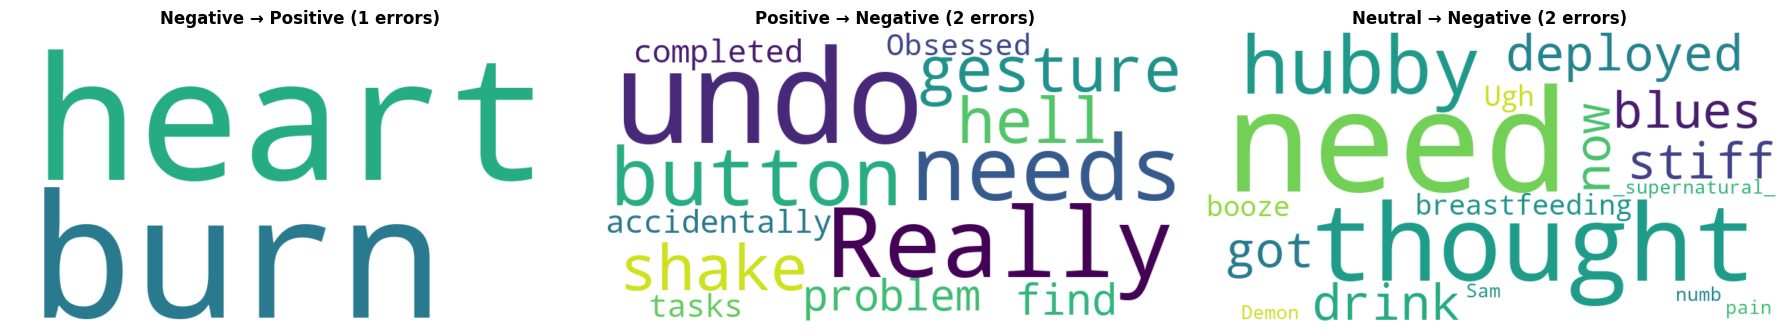


--- WORD CLOUDS FOR TRANSFORMER (High-Confidence Errors) ---


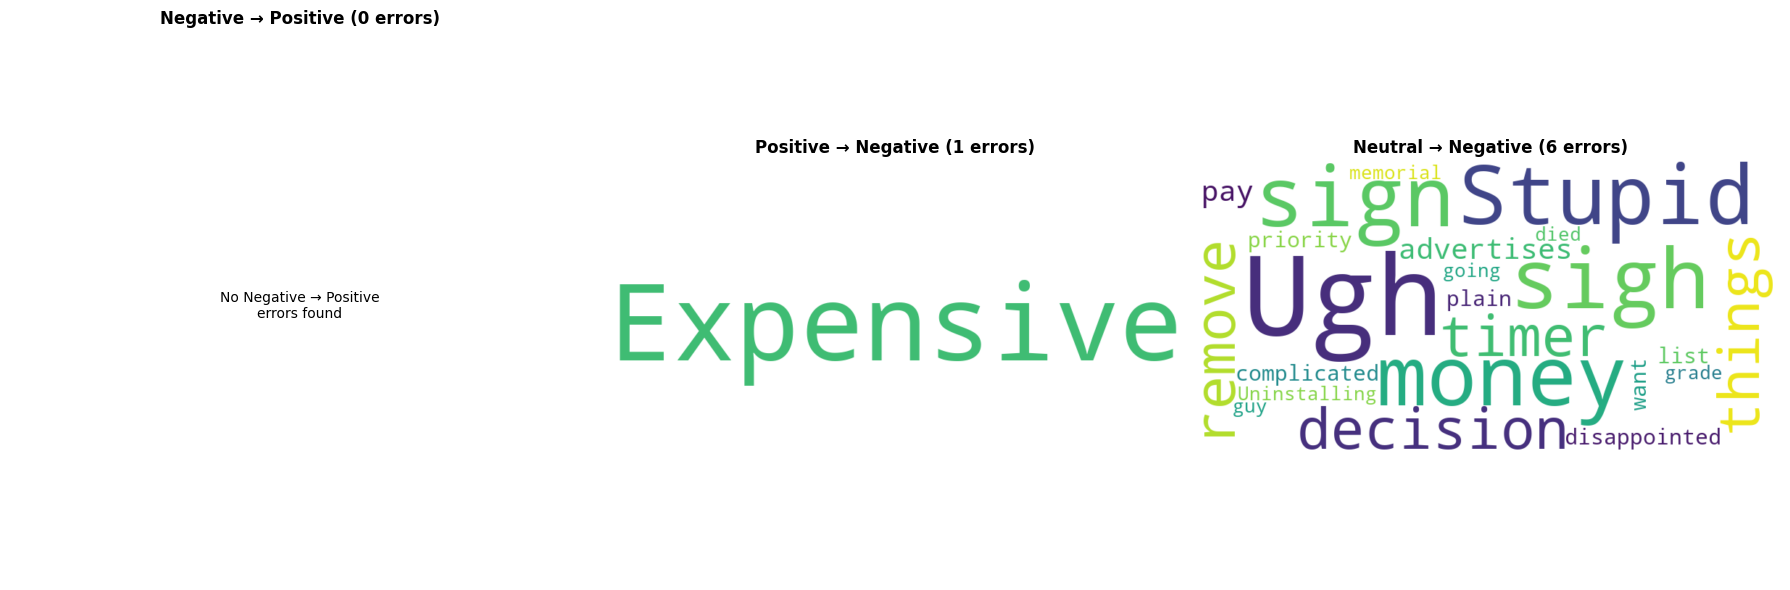


--- WORD CLOUDS FOR FASTTEXT (High-Confidence Errors) ---


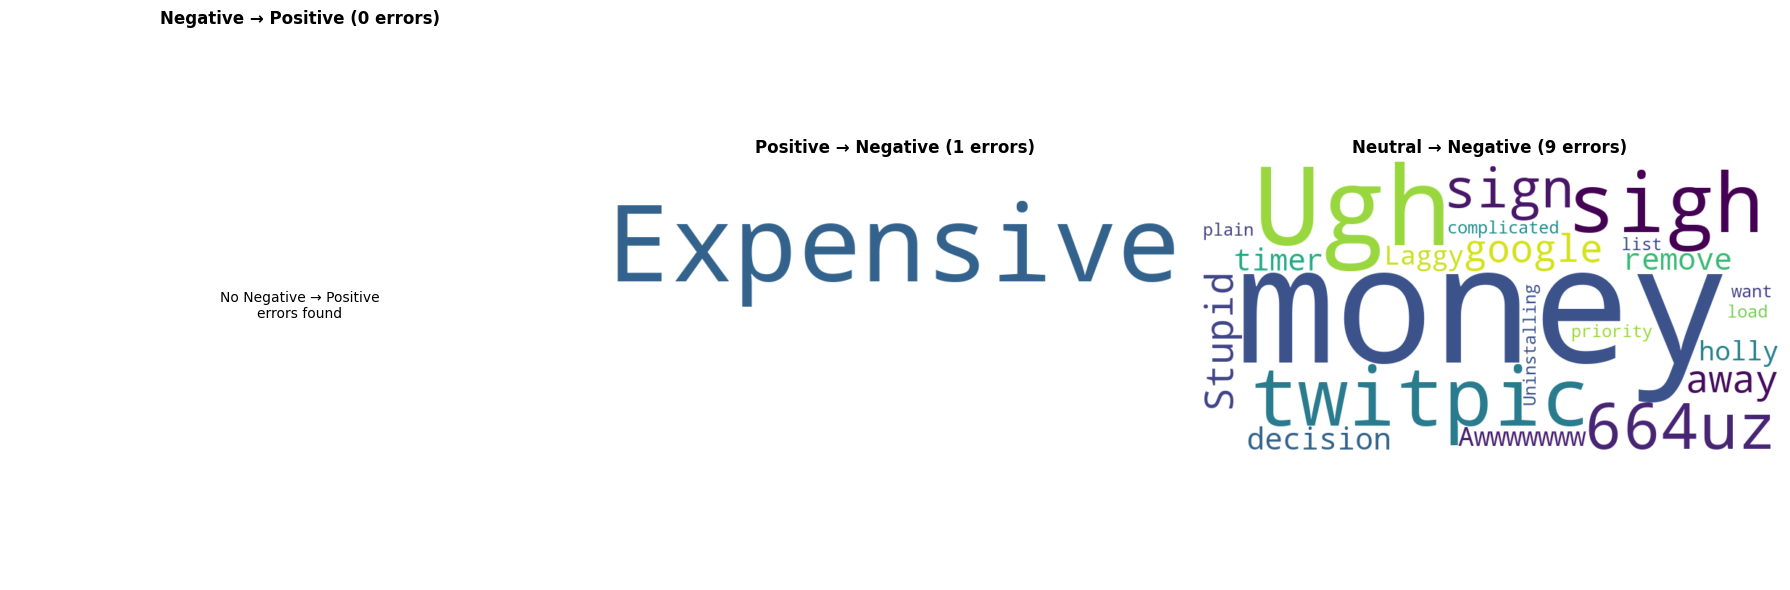

In [12]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Define the error types you want to visualize
error_types = [
    ('Negative', 'Positive'),
    ('Positive', 'Negative'),
    ('Neutral', 'Negative') # You can add more pairs like ('Neutral', 'Positive'), etc.
]

valid_models_data = {name: data for name, data in all_model_data.items() if not data.empty}

if valid_models_data:
    for model_name, data in valid_models_data.items():
        print(f"\n--- WORD CLOUDS FOR {model_name.upper()} (High-Confidence Errors) ---")
        
        # Calculate number of rows needed for subplots (each row holds up to 3 word clouds)
        num_error_types = len(error_types)
        n_cols = 3
        n_rows = (num_error_types + n_cols - 1) // n_cols # Ceiling division
        
        if n_rows > 0:
            fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 6*n_rows))
            # Handle case where there's only one row or one subplot
            if n_rows == 1:
                if n_cols == 1:
                    axes = [axes]
                else:
                    axes = axes if num_error_types > 1 else [axes]
            else:
                axes = axes.flatten() if num_error_types > 1 else [axes[0]] # Flatten for easy indexing
            
            for idx, (true_label, pred_label) in enumerate(error_types):
                subset = data[(data['true_label'] == true_label) & 
                              (data['predicted_label'] == pred_label)]
                
                if len(subset) > 0:
                    all_text = ' '.join(subset['text'].astype(str).tolist()) # Ensure text is string
                    
                    # Check if there's enough text to generate a wordcloud
                    if all_text.strip():
                        wordcloud = WordCloud(
                            width=800, height=400,
                            background_color='white',
                            max_words=50,
                            collocations=False, # Avoid repeated bigrams
                            regexp=r'\w[\w\'\-]+\w' # Include hyphens and apostrophes if relevant
                        ).generate(all_text)
                        
                        axes[idx].imshow(wordcloud, interpolation='bilinear')
                        axes[idx].axis('off')
                        axes[idx].set_title(f'{true_label} → {pred_label} ({len(subset)} errors)', 
                                          fontsize=12, fontweight='bold')
                    else:
                        axes[idx].text(0.5, 0.5, f'No text\navailable\nfor {true_label} → {pred_label}\n({len(subset)} errors)', 
                                       horizontalalignment='center', verticalalignment='center', 
                                       transform=axes[idx].transAxes, fontsize=10)
                        axes[idx].axis('off') # Turn off axis for empty plot
                        axes[idx].set_title(f'{true_label} → {pred_label} ({len(subset)} errors)', 
                                          fontsize=12, fontweight='bold')
                else:
                    # No errors of this type, show an empty plot with title
                    axes[idx].text(0.5, 0.5, f'No {true_label} → {pred_label}\nerrors found', 
                                   horizontalalignment='center', verticalalignment='center', 
                                   transform=axes[idx].transAxes, fontsize=10)
                    axes[idx].axis('off') # Turn off axis for empty plot
                    axes[idx].set_title(f'{true_label} → {pred_label} (0 errors)', 
                                      fontsize=12, fontweight='bold')
            
            # Hide any unused subplots if the grid is larger than the number of error types
            for j in range(idx + 1, len(axes)):
                axes[j].axis('off')
            
            plt.tight_layout()
            plt.show()
        else:
            print(f"  No high-confidence error data for {model_name} to generate word clouds.")

else:
    print("No valid model data with high-confidence errors available for word cloud generation.")


CORRELATIONS BY MODEL
                                    confidence  true_prob  \
Model                                                       
bilstm      confidence                   1.000      0.049   
            true_prob                    0.049      1.000   
            calculated_text_length      -0.126      0.063   
fasttext    confidence                   1.000     -0.980   
            true_prob                   -0.980      1.000   
            calculated_text_length      -0.304      0.330   
transformer confidence                   1.000     -0.406   
            true_prob                   -0.406      1.000   
            calculated_text_length      -0.276      0.293   

                                    calculated_text_length  
Model                                                       
bilstm      confidence                              -0.126  
            true_prob                                0.063  
            calculated_text_length                   1.000  


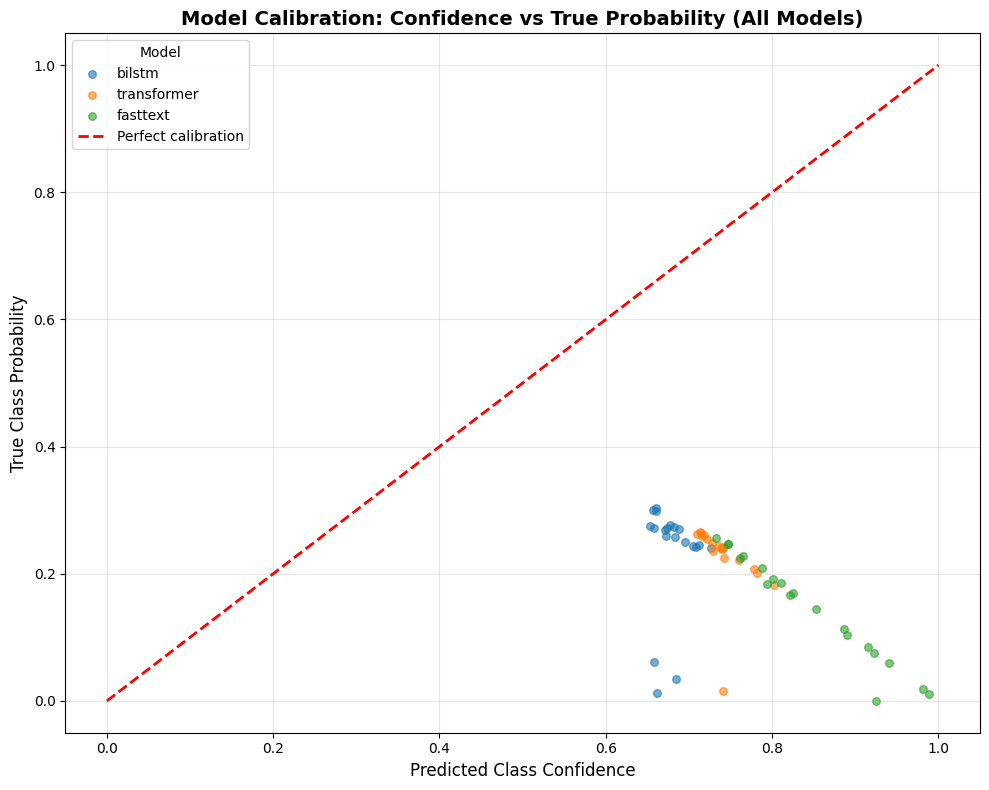

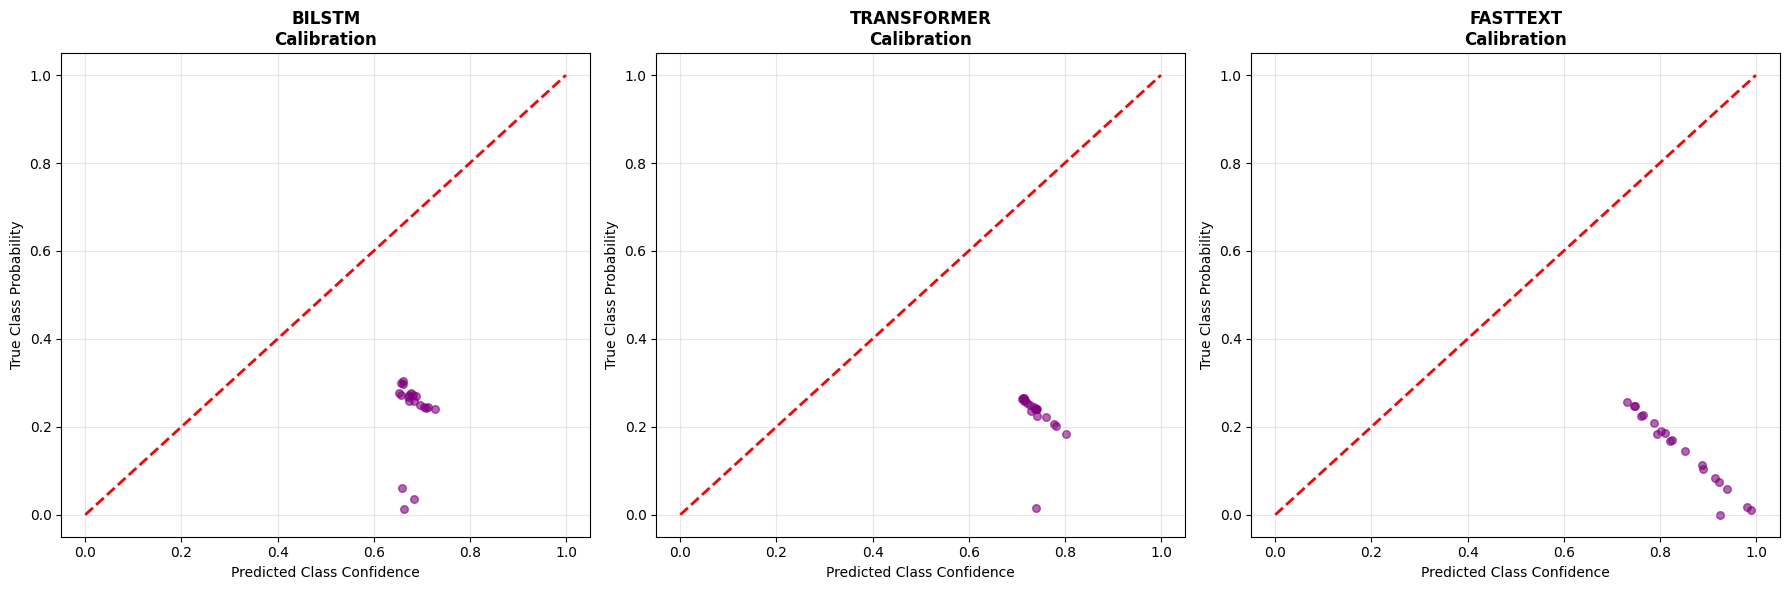

In [15]:
import matplotlib.pyplot as plt
import pandas as pd # all_model_data contains the DataFrames

# Define the mapping from label string to index (same for all models)
label_to_idx = {'Negative': 0, 'Neutral': 1, 'Positive': 2}

valid_models_data = {name: data for name, data in all_model_data.items() if not data.empty}

if valid_models_data:
    # Calculate correlations for all models together first
    all_data_combined_calib = []
    for model_name, data in valid_models_data.items():
        # Calculate true_prob for each model's data
        data['true_prob'] = data.apply(
            lambda row: row['probabilities'][label_to_idx[row['true_label']]], axis=1
        )
        # Add a column for the model name
        data_with_model = data.copy()
        data_with_model['Model'] = model_name
        all_data_combined_calib.append(data_with_model)

    if all_data_combined_calib:
        combined_df_calib = pd.concat(all_data_combined_calib, ignore_index=True)
        
        # Overall Correlation Matrix (across models, for selected columns)
        correlation_all = combined_df_calib[['confidence', 'true_prob', 'calculated_text_length', 'Model']].groupby('Model').corr(numeric_only=True).round(3)
        print("\nCORRELATIONS BY MODEL")
        print("="*80)
        print(correlation_all)

        # Calibration Scatter Plot (Overlay all models)
        plt.figure(figsize=(10, 8))
        for model_name in valid_models_data.keys():
            model_subset = combined_df_calib[combined_df_calib['Model'] == model_name]
            plt.scatter(model_subset['confidence'], model_subset['true_prob'], 
                       alpha=0.6, label=model_name, s=30) # Reduced marker size for clarity

        plt.plot([0, 1], [0, 1], 'r--', linewidth=2, label='Perfect calibration')
        plt.xlabel('Predicted Class Confidence', fontsize=12)
        plt.ylabel('True Class Probability', fontsize=12)
        plt.title('Model Calibration: Confidence vs True Probability (All Models)', fontsize=14, fontweight='bold')
        plt.legend(title='Model')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

        # Individual Calibration Plots (Per Model)
        num_models = len(valid_models_data)
        fig, axes = plt.subplots(1, num_models, figsize=(6*num_models, 6))
        if num_models == 1:
            axes = [axes]

        ax_idx = 0
        for model_name, data in valid_models_data.items():
            axes[ax_idx].scatter(data['confidence'], data['true_prob'], alpha=0.6, color='purple', s=30)
            axes[ax_idx].plot([0, 1], [0, 1], 'r--', linewidth=2, label='Perfect calibration')
            axes[ax_idx].set_xlabel('Predicted Class Confidence', fontsize=10)
            axes[ax_idx].set_ylabel('True Class Probability', fontsize=10)
            axes[ax_idx].set_title(f'{model_name.upper()}\nCalibration', fontsize=12, fontweight='bold')
            # axes[ax_idx].legend() # Legend is redundant here, shown in overall plot
            axes[ax_idx].grid(True, alpha=0.3)
            ax_idx += 1

        plt.tight_layout()
        plt.show()

else:
    print("No valid model data with probabilities to perform calibration analysis.")

In [16]:
print("\nERROR PATTERNS SUMMARY (High-Confidence Errors)")
print("="*80)

for model_name, data in all_model_data.items():
    if not data.empty:
        print(f"\n--- {model_name.upper()} ---")
        for true_label in data['true_label'].unique():
            print(f"\n{true_label.upper()} Misclassifications (in High-Conf Errors):")
            # Filter the dataframe for the current true label
            subset = data[data['true_label'] == true_label]
            
            print(f"  Total (in high-conf set): {len(subset)}")
            print(f"  Average confidence: {subset['confidence'].mean():.3f}")
            # Use the calculated column name
            print(f"  Average text length: {subset['calculated_text_length'].mean():.1f} words")
            
            print(f"  Misclassified as (in high-conf set):")
            for pred_label in subset['predicted_label'].unique():
                count = len(subset[subset['predicted_label'] == pred_label])
                # Calculate percentage relative to *this subset* (misclassifications of 'true_label')
                percentage = (count / len(subset)) * 100 if len(subset) > 0 else 0 
                print(f"    - {pred_label}: {count} ({percentage:.1f}%)")
    else:
        print(f"\n--- {model_name.upper()} ---")
        print("  No high-confidence error data available for summary.")


ERROR PATTERNS SUMMARY (High-Confidence Errors)

--- BILSTM ---

NEUTRAL Misclassifications (in High-Conf Errors):
  Total (in high-conf set): 17
  Average confidence: 0.681
  Average text length: 8.9 words
  Misclassified as (in high-conf set):
    - Positive: 15 (88.2%)
    - Negative: 2 (11.8%)

POSITIVE Misclassifications (in High-Conf Errors):
  Total (in high-conf set): 2
  Average confidence: 0.673
  Average text length: 10.5 words
  Misclassified as (in high-conf set):
    - Negative: 2 (100.0%)

NEGATIVE Misclassifications (in High-Conf Errors):
  Total (in high-conf set): 1
  Average confidence: 0.658
  Average text length: 3.0 words
  Misclassified as (in high-conf set):
    - Positive: 1 (100.0%)

--- TRANSFORMER ---

NEUTRAL Misclassifications (in High-Conf Errors):
  Total (in high-conf set): 19
  Average confidence: 0.740
  Average text length: 15.9 words
  Misclassified as (in high-conf set):
    - Positive: 13 (68.4%)
    - Negative: 6 (31.6%)

POSITIVE Misclassificat